In [177]:
import numpy as np
import random
import math

import matplotlib.pyplot as plt

import torch

from bindsnet.network import Network
from bindsnet.network.nodes import Input, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

In [178]:
def connect_one_to_one(n_pre, n_post):
    """
    1 on the main diagonal (i -> i), 0 elsewhere.
    Extra rows/cols stay 0 if sizes differ.
    """
    A = np.zeros((n_pre, n_post), dtype=np.float32)
    np.fill_diagonal(A, 1)
    return A

def connect_all_to_all(n_pre, n_post, exclude_self=True):
    """
    All ones. If square and exclude_self=True, zero the diagonal.
    """
    A = np.ones((n_pre, n_post), dtype=np.float32)
    if exclude_self and n_pre == n_post:
        np.fill_diagonal(A, 0)
    return A

def connect_random(n_pre, n_post, p=0.1, exclude_self=True):
    """
    Each edge present with prob p (independent).
    """
    A = (np.random.rand(n_pre, n_post) < p).astype(np.float32)
    if exclude_self and n_pre == n_post:
        np.fill_diagonal(A, 0)
    return A

def connect_distance(n_neurons, _, sigma=3.0, p_max=0.5, circular=False, exclude_self=True):
    """
    Distance-dependent binary connectivity (1D).
    - Neurons are placed on a 1D line with indices 0..n-1.
    - Connection prob decays with distance: p_ij = p_max * exp(-(d_ij^2)/(2*sigma^2))
    - If circular=True, distance wraps around (ring topology).

    Computes:
        A   : [n, n] binary adjacency (0/1)
        P   : [n, n] connection probabilities used
        D   : [n, n] pairwise distances
        
    Returns:
        A   : [n, n] binary adjacency (0/1)
    """
    idx = np.arange(n_neurons)
    D = np.abs(idx[:, None] - idx[None, :])  # |i-j|
    if circular:
        D = np.minimum(D, n_neurons - D)     # wrap-around distance on a ring

    # Pprobabilities decay exponentially with distance
    P = p_max * np.exp(-(D**2) / (2.0 * sigma**2))

    # Sample connections
    A = (np.random.rand(n_neurons, n_neurons) < P).astype(np.float32)

    if exclude_self:
        np.fill_diagonal(A, 0)
        P[np.diag_indices(n_neurons)] = 0.0

    return A

In [179]:
def poisson_input(
    T, n_neurons, dt,
    target_idx,
    target_rate,
    bg_rate,
    batch_size=1
):
    """
    Generate Poisson spike trains in numpy.

    Args:
        T             : number of time steps
        n_neurons     : number of neurons
        dt            : timestep (ms)
        target_idx    : list of target neuron indices
        target_rate   : firing rate for target neurons (Hz)
        bg_rate       : firing rate for all other neurons (Hz)
        batch_size    : number of batches

    Returns:
        spikes : NumPy array [T, batch_size, n_neurons] of 0/1
    """
    # baseline rates
    rates = np.full(n_neurons, bg_rate, dtype=np.float32)
    rates[np.array(target_idx, dtype=int)] = target_rate

    # probability per step
    p = rates * (dt / 1000.0)  # Hz × s
    p = np.clip(p, 0.0, 1.0)

    # sample
    rand = np.random.rand(T, batch_size, n_neurons)
    spikes = (rand < p).astype(np.float32)
    return spikes

In [ ]:
def connect_clustered_lateral(n_neurons, n_clusters = None, cluster_size= None,p_intra=0.8, evenly_spaced=True, connect_clusters=True, exclude_self=True):
    """
    This function creates a clustered connectivity matrix. 
    Neurons should be organized in clusters, with higher connection probability within clusters than between clusters.
    Args:
        n_neurons       : number of neurons
        n_clusters     : number of clusters (if None, computed from cluster_size)
        cluster_size   : size of each cluster (if None, computed from n_clusters)
        p_intra        : probability of connection within a cluster
        p_inter        : probability of connection between clusters
        evenly_spaced  : if True, clusters are evenly spaced; if False, clusters are random
        connect_clusters: if True, connect clusters with p_inter; if False, only intra-cluster connections
        exclude_self   : if True, no self-connections
    """
    p_inter=0.4 # probability of connection between neurons in different clusters
    p_connect_cluster = 0.33 # probability of inhibitory connection between clusters
    
    if n_clusters is None and cluster_size is None:
        n_clusters = int(np.sqrt(n_neurons))
    if cluster_size is None:
        cluster_size = n_neurons // n_clusters
    if n_clusters is None:
        n_clusters = n_neurons // cluster_size

    A = np.zeros((n_neurons, n_neurons), dtype=np.float32)

    # Determine cluster indices
    if evenly_spaced:
        cluster_indices = [list(range(i * cluster_size, (i + 1) * cluster_size)) for i in range(n_clusters)]
    else:
        all_indices = np.arange(n_neurons)
        np.random.shuffle(all_indices)
        cluster_indices = [all_indices[i * cluster_size:(i + 1) * cluster_size].tolist() for i in range(n_clusters)]

    # Intra-cluster connections
    for indices in cluster_indices:
        for i in indices:
            for j in indices:
                if i != j or not exclude_self:
                    if np.random.rand() < p_intra:
                        A[i, j] = np.random.rand() * 0.8 + 0.2 

    # Inhibitory connections between clusters
    if connect_clusters:
        for i in range(n_clusters):
            for j in range(i + 1, n_clusters):
                if np.random.rand() < p_connect_cluster:
                    for pre in cluster_indices[i]:
                        for post in cluster_indices[j]:
                            A[pre, post] = -(np.random.rand())
                            A[post, pre] = -(np.random.rand()) # symmetric inhibitory connection

    # Random connections
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i != j:
                for pre in cluster_indices[i]:
                    for post in cluster_indices[j]:
                        if np.random.rand() < p_inter:
                            # random between -1 and 1
                            A[pre, post] = np.random.rand() * 2 - 1

    # Exclude self-connections if specified
    if exclude_self:
        np.fill_diagonal(A, 0)

    return A
    

In [269]:
# function to plot forward and lateral weights and output spikes
# gets the parameters of a single layer
def plot_network(forward_weights, lateral_weights, spikes, layer_name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot forward weights
    axes[0].imshow(forward_weights.cpu().numpy(), cmap='hot', interpolation='nearest')
    axes[0].set_title(f'Forward Weights - {layer_name}')
    axes[0].set_xlabel('Post-synaptic Neurons')
    axes[0].set_ylabel('Pre-synaptic Neurons')
    axes[0].invert_yaxis()

    # Plot lateral weights
    axes[1].imshow(lateral_weights.cpu().numpy(), cmap='hot', interpolation='nearest', origin='lower')
    axes[1].set_title(f'Lateral Weights - {layer_name}')
    axes[1].set_xlabel('Post-synaptic Neurons')
    axes[1].set_ylabel('Pre-synaptic Neurons')
    # add colorbar
    plt.colorbar(axes[1].images[0], ax=axes[1])

    # Plot spikes
    axes[2].imshow(spikes.cpu().numpy().T, aspect='auto', cmap='gray_r', interpolation='nearest')
    axes[2].set_title(f'Spikes - {layer_name}')
    axes[2].set_xlabel('Time Steps')
    axes[2].set_ylabel('Neurons')
    axes[2].invert_yaxis()

    plt.tight_layout()
    plt.show()
    
# function to plot initial input spikes
def plot_input(input_spikes):
    plt.figure(figsize=(10, 5))
    plt.imshow(input_spikes.cpu().numpy().squeeze().T, aspect='auto', cmap='gray_r', interpolation='nearest')
    plt.title('Input Spikes')
    plt.xlabel('Time Steps')
    plt.ylabel('Input Neurons')
    # invert y axis
    plt.gca().invert_yaxis()
    plt.show()

In [494]:
def generate_input(target_rate=10, bg_rate=5):
# Stimulate a group of neurons noisily
    target_idx  = np.concatenate([np.arange(0,14), np.arange(52, 76), np.arange(80, 100), np.arange(200,300)])

    poisson_spikes = poisson_input(
        T, n_inputs, dt,
        target_idx,
        target_rate,
        bg_rate,
        batch_size=1)

    return poisson_spikes

In [496]:
# Params
n_inputs   = 300
n_neurons  = 300
n_neurons2 = 300
n_neurons3 = 300
dt         = 1.0
sim_length = 400
T          = int(sim_length / dt)
n_clusters = 20
weight_factor_lateral = 5.0
weight_factor_ff = 5.0

# Generate input
I_ext = torch.from_numpy(generate_input(target_rate=60, bg_rate=10)).float()

# Network
net = Network(dt=dt)

inp    = Input(n=n_inputs)                 # spike source
adlif1 = AdaptiveLIFNodes(n=n_neurons)      # spiking layer
adlif2 = AdaptiveLIFNodes(n=n_neurons2)      # spiking layer
adlif3 = AdaptiveLIFNodes(n=n_neurons3)      # spiking layer

net.add_layer(inp, name="Input")
net.add_layer(adlif1, name="AdLIF 1")
net.add_layer(adlif2, name="AdLIF 2")
net.add_layer(adlif3, name="AdLIF 3")

# Build feedforward connectivity
connections_ff = connect_one_to_one(n_inputs, n_neurons)
weights_ff     = np.random.rand(n_inputs, n_neurons).astype(np.float32) * weight_factor_ff
w_ff           = torch.from_numpy(connections_ff * weights_ff*2)
net.add_connection(Connection(source=inp, target=adlif1, w=w_ff), source="Input", target="AdLIF 1")

# Build feedforward connectivity 2
connections_ff2 = connect_one_to_one(n_neurons, n_neurons2)
weights_ff2     = np.random.rand(n_neurons, n_neurons2).astype(np.float32) * weight_factor_ff
w_ff2           = torch.from_numpy(connections_ff2 * weights_ff2)
net.add_connection(Connection(source=adlif1, target=adlif2, w=w_ff2), source="AdLIF 1", target="AdLIF 2")

# Build feedforward connectivity 3

connections_ff3 = connect_one_to_one(n_neurons2, n_neurons3)
weights_ff3     = np.random.rand(n_neurons2, n_neurons3).astype(np.float32) * weight_factor_ff
w_ff3 = torch.from_numpy(connections_ff3 * weights_ff3)
net.add_connection(Connection(source=adlif2, target=adlif3, w=w_ff3), source="AdLIF 2", target="AdLIF 3")

# Build lateral connectivity
connections_lat = connect_all_to_all(n_neurons, n_neurons)
weights_lat    = connect_clustered_lateral(n_neurons, n_clusters=n_clusters, p_intra=0.8, connect_clusters=True, exclude_self=True) * weight_factor_lateral
w_lat           = torch.from_numpy(connections_lat * weights_lat)
net.add_connection(Connection(source=adlif1, target=adlif1, w=w_lat), source="AdLIF 1", target="AdLIF 1")

# Build lateral connectivity 2
connections_lat2 = connect_all_to_all(n_neurons2, n_neurons2)
weights_lat2    = connect_clustered_lateral(n_neurons2, n_clusters=n_clusters, p_intra=0.8, connect_clusters=True, exclude_self=True) * weight_factor_lateral
w_lat2           = torch.from_numpy(connections_lat2 * weights_lat2)
net.add_connection(Connection(source=adlif2, target=adlif2, w=w_lat2), source="AdLIF 2", target="AdLIF 2")

# Build lateral connectivity 3
connections_lat3 = connect_all_to_all(n_neurons3, n_neurons3)
weights_lat3    = connect_clustered_lateral(n_neurons3, n_clusters=n_clusters, p_intra=0.8, connect_clusters=True, exclude_self=True) * weight_factor_lateral
w_lat3           = torch.from_numpy(connections_lat3 * weights_lat3)
net.add_connection(Connection(source=adlif3, target=adlif3, w=w_lat3), source="AdLIF 3", target="AdLIF 3")

# monitors for all layers
mon_s1 = Monitor(net.layers["AdLIF 1"], ["s"], time=T)
mon_v1 = Monitor(net.layers["AdLIF 1"], ["v"], time=T)
net.add_monitor(mon_s1, name="s1")
net.add_monitor(mon_v1, name="v1")
mon_s2 = Monitor(net.layers["AdLIF 2"], ["s"], time=T)
mon_v2 = Monitor(net.layers["AdLIF 2"], ["v"], time=T)
net.add_monitor(mon_s2, name="s2")
net.add_monitor(mon_v2, name="v2")
mon_s3 = Monitor(net.layers["AdLIF 3"], ["s"], time=T)
mon_v3 = Monitor(net.layers["AdLIF 3"], ["v"], time=T)
net.add_monitor(mon_s3, name="s3")
net.add_monitor(mon_v3, name="v3")

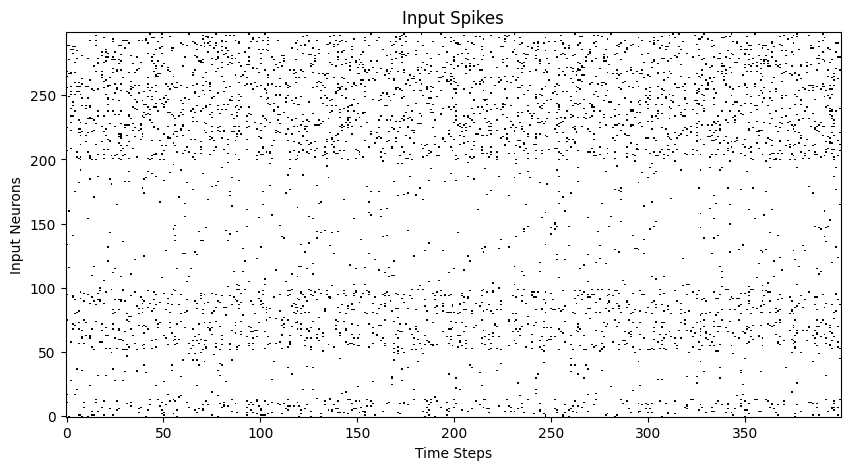

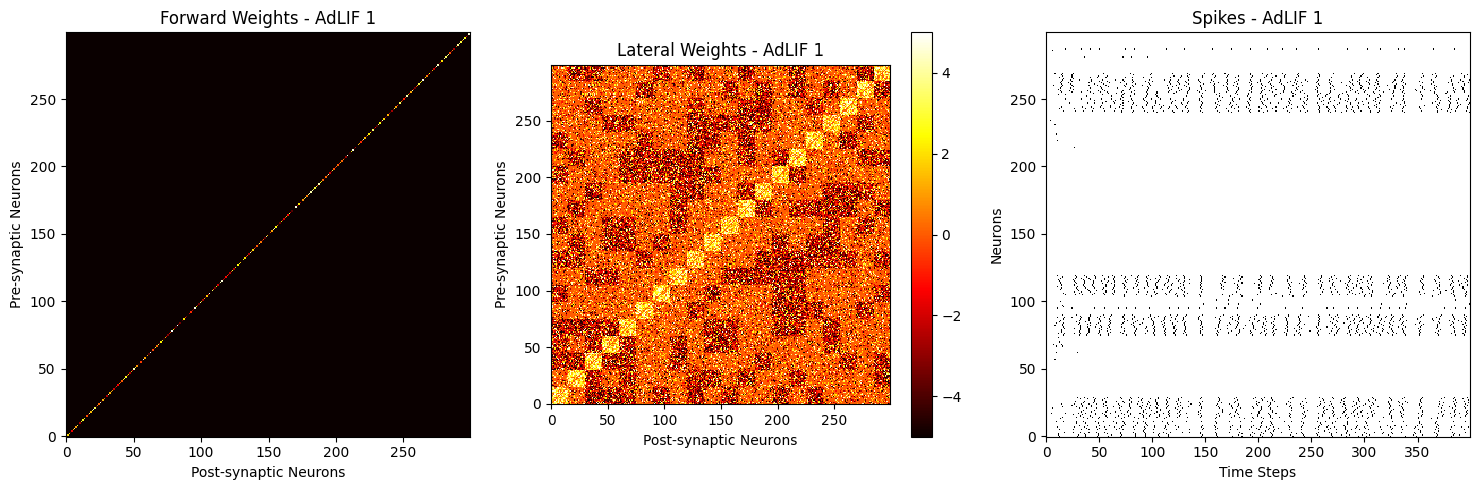

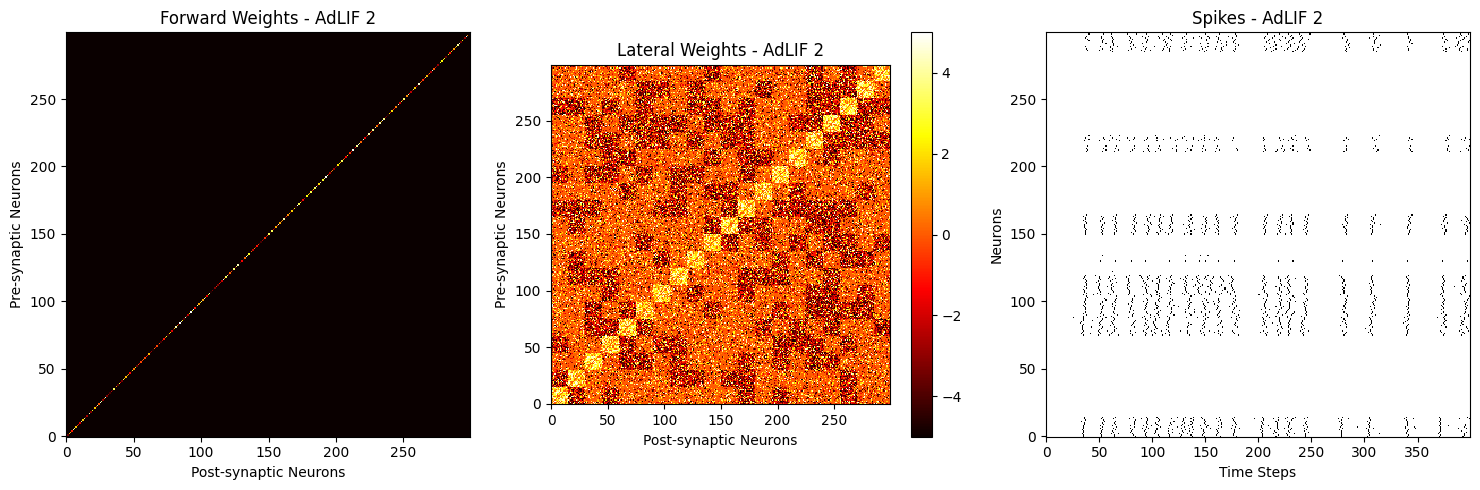

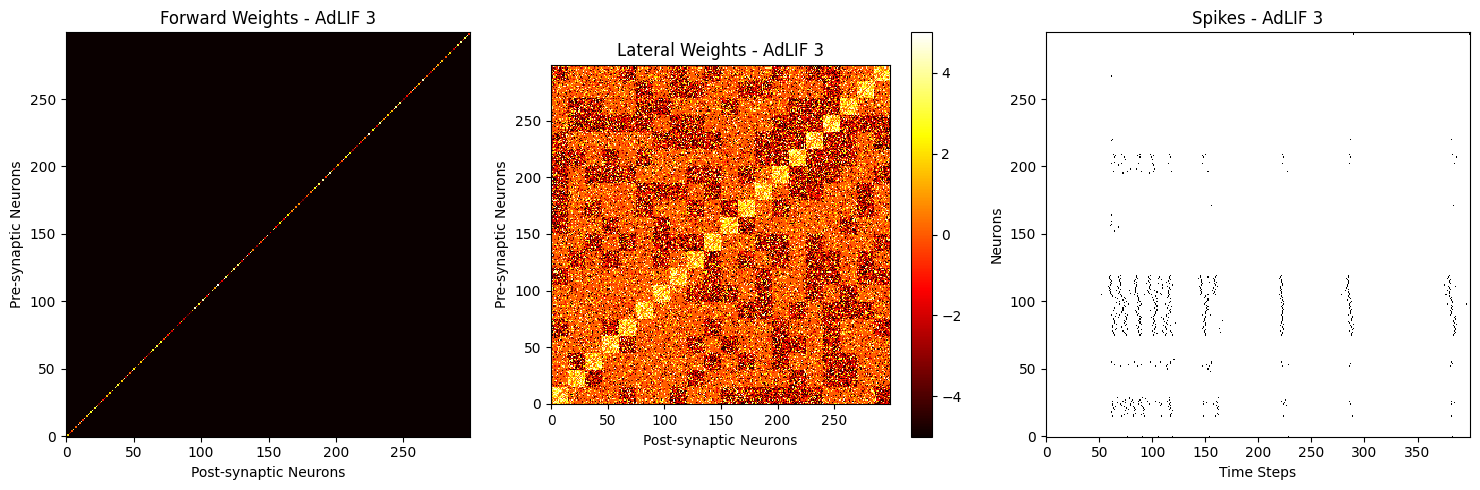

In [497]:
# Run with Poisson spikes into the Input layer 
net.run(inputs={"Input": I_ext}, time=T)

s1 = mon_s1.get("s").squeeze(1)  # [T, n_neurons]
v1 = mon_v1.get("v").squeeze(1)  # [T, n_neurons]
s2 = mon_s2.get("s").squeeze(1)  # [T, n_neurons2]
v2 = mon_v2.get("v").squeeze(1)  # [T, n_neurons2]
s3 = mon_s3.get("s").squeeze(1)  # [T, n_neurons3]
v3 = mon_v3.get("v").squeeze(1)  # [T, n_neurons3]

# plot initial input spikes
plot_input(I_ext.squeeze(1))
# plot all layers and lateral connections
plot_network(w_ff, w_lat, s1, "AdLIF 1")
plot_network(w_ff2, w_lat2, s2, "AdLIF 2")
plot_network(w_ff3, w_lat3, s3, "AdLIF 3")